# Machine Learning Project

In [ ]:
# Daniel Moskalchuk 293172
# Julia Tankiewicz 293719
# Nikita Bondarchuk 294478

The assignments below should be solved and documented as a project that will form the basis for the
examination. When solving the exercises it is important that you

  * document all relevant results and analyses that you have obtained/performed during the exercises.
  * try to relate your results to the theoretical background of the methods being applied.

Feel free to add cells if you need to.

Please hand in assignment 1-6 in a _**single**_ Jupyter notebook where you retain the questions outlined below. You are welcome to adapt code from the web (e.g. Kaggle kernels), but you **_must_** reference the original source in your notebook. In addition to _clean, well-documented code_ (i.e. functions with <a href="https://www.geeksforgeeks.org/python-docstrings/">docstrings</a>, etc), your notebook will be judged according to how well each step is explained (using Markdown). 

In general, direct questions regarding assignments 1, 4, 5 and 6 to Frederik, and questions regarding assignments 2, 3, and 7 to Richard. 

Last, but not least:
* Looking for an overview of the markdown language? The cheat sheet <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">here</a> might help.
* For the Python specific components of the exercises, you should not need constructs beyond those that are already included in the notebooks on the course's web-page (still you should not feel constrained by these, so feel free to be adventurous). You may, however, need to consult the documentation for some of the methods supplied by `sklearn`.

**Groups:** Create your own groups. May be across teams. 2-4 students per group. No one-person groups.


**Submission deadline:** Thursday, December 15 before 13.00 CET (Notebooks + presentation recording)

**Expected workload:** Each student is expected to spend around around 50 hours on the project.

### Deliverables
The teams have to submit three deliverables before the submission deadline: 1) a notebook of assignments 1-6, 2) a notebook of assignment 7, and 3) presentation video uploaded to some online platform e.g. YouTube, Vimeo, etc.

#### Notebook
The notebook contains all the code to explore the dataset, train the final model and documents each step clearly. If code is copied from another codebase such as Github or Stack Overflow it **_must_** be properly referenced.


#### Presentation
The presentation video should be 15 min long and should highlight the problem you are solving, interesting things you found in the data and the step involved in building up your model. At the exam we will discuss the presentation and ask questions about your project and submissions. A link to the video must be placed in the notebook for assignment 7.

### Randomness
For ALL random states, choose state = 69 so we can replicate your work.


In [2]:
# Import all necessary modules here:
#pip install opencv-python
#pip install keras
#pip install --no-cache-dir tensorflow
from pathlib import Path
import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn import (decomposition, ensemble, metrics)
#from sklearn import (neighbors, datasets, decomposition, ensemble,metrics, model_selection, preprocessing, linear_model)


#from keras.preprocessing import image
#from tensorflow.keras.utils import load_img, img_to_array


## 1. The IceCat Dataset

__You should be able to do this exercise after Lecture 3.__

The IceCat Dataset, kindly provided to us by Stibo Systems, contains a large amount of data on different office products. As an example of "real-world" data, these data are imperfect and incomplete. As such, this exercise is not so much an exercise in creating a good machine learning model, but places a larger emphasis on "cleaning the data".

We are going to work with a subset of the IceCat Dataset. In particular, you will be provided with a zip file of 5,854 images of office products, each with the name "product ID".jpg. You will also be provided with a list of colors, `colors.txt`, which, when imported using the code below, is a list of tuples of the form `[("product ID", "color"), ...]`. (The code below assumes that `colors.txt` is in the same folder as the jupyter notebook. Feel free to change the code if you prefer a different organization of your files).

Your task is to clean up the data and construct a simple machine learning model (_e.g._, _k_-nearest neighbor) that can identify the color of a product. You have free hands - there is hardly any one "correct answer" - but you need to argue for your choices. Among other things, you probably need to think about the following as you work with the data:

* All of the images have different sizes.

* Some of the images are RGB images (3 layers), others are CMYK (4 layers), some might even be black-and-white (1 layer).

* Some colors are only represented by very few products.

* Some colors are very similar, such as "Purple" and "Violet".

* A product may have a particular color, but a packaging of a different color. Similarly, the color of, say, a computer monitor may be black, while the image of it could show a monitor that is turned on with a green screensaver.

* Many products are attributed to several colors, such as "Black, Blue" or even "Blue, Green, Orange, Violet, Yellow". Yet others are described as "Multicolor" or "Assorted colors".

Again, you have free hands in how you are going to solve these (and other) challenges, but you must argue for and reflect on your choices as you progress.


In [136]:
# for some binning
color_mappings = {
  # source color => arr of colors associated with the source color
    'Grey' : ['Silver', 'Metallic', 'Aluminium', 'Stainless steel', 'Platinum', 'Graphite', 'Chrome', 'Anthracite','Light Grey','Charcoal','Titanium','Light grey'],
    'Purple' : ['Violet', 'Lavender', 'Fuchsia','Magenta'],
    'Transparent' : ['Translucent'],
    'Cream' : ['Beige', 'Sand', 'Tan','Cappuccino','Ivory'],
    'Brown' : ['Oak colour', 'Wood','Bronze'],
    'Cyan' : ['Turquoise', 'Aqua colour'],
    'White' : ['Pearl' ],
    'Pink' : ['Rose'],
    'Red' : ['Cherry', 'Bordeaux'],
    'Green' : ['Pine', 'Lime','Olive'],
    'Yellow' : ['Gold'],
    'Blue' : ['Navy'],
    'Multicolour' : ['Multi','Assorted colours']
}

def colors_binning(initial_color):
    for source_color in color_mappings:
        if initial_color in color_mappings[source_color]: return source_color;
        
    return initial_color;
        
with open("datasets/1/colors.txt","r") as file:
    colors = ast.literal_eval(file.read())
    # lets create a dataframe
    d = {'pic_id': [], 'color': []}
    for row in colors:
        # check if there are more colors in one row
        colors_arr = row[1].split(", ")
        # if there are more than 1 color
        if(len(colors_arr) > 1):
            # insert a row for each color
            for color in colors_arr:  
                d['pic_id'].append(row[0])
                d['color'].append(colors_binning(color)) 
        else:
            d['pic_id'].append(row[0])
            d['color'].append(colors_binning(row[1])) 
            

    pic_colors = pd.DataFrame(data=d)
    display(pic_colors)
    # lets see the distribution of colors. We will try to bin the repeating colors to the most common alternatives.
    display(pic_colors.color.value_counts())
    
    

,pic_id,color
0,1710,Blue
1,1710,White
2,1983,Cream
3,19832,Grey
4,23112,Black
...,...,...
7513,89527433,Black
7514,90111420,Black
7515,91233324,Black
7516,91689185,White


Black          1497
Grey           1287
White          1231
Blue            814
Green           441
Transparent     431
Red             403
Yellow          335
Multicolour     259
Brown           228
Orange          204
Pink            182
Purple          136
Cream            36
Cyan             34
Name: color, dtype: int64

In [137]:
def load_image_files(container_path, dimension=(64, 64), nr_of_colors = 16):
    image_dir = Path(container_path)
    count = 0
    img_hash = {}
    for file in image_dir.iterdir():
        count += 1
        if count > 10:
            break;
            
        img = plt.imread(file)
        img_resized = cv.resize(img, dimension, interpolation=cv.INTER_AREA)
        #img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        # Lets compress the image using clusters
        # https://github.com/mbeyeler/opencv-machine-learning/blob/master/notebooks/08.02-Compressing-Color-Images-Using-k-Means.ipynb
        
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        #flags = cv.KMEANS_RANDOM_CENTERS
        flags = cv.KMEANS_PP_CENTERS
        
        compactness, labels, centers = cv.kmeans(np.float32(img_resized.reshape((-1, 3))),
                                        nr_of_colors, None, criteria, 10, flags)
        
        centers = np.uint8(centers)
        new_colors = centers[labels.flatten()]
        
        img_recolored = new_colors.reshape(img_resized.shape)
        
        
        plt.title(file.stem)
        plt.imshow(img_recolored)
        #img_pred = img_to_array(img_pred)
        #img_pred = img_pred / 255
        img_hash[file.stem] = img_recolored
    return img_hash

In [138]:
def getColorPctPerImage(ignoreWhite = True, colorRound = 2, whiteThreshold = 0):
    images_hash = load_image_files("datasets/1/images")

    dfMock = {'img_id':[], 'red': [], 'green': [], 'blue': [], 'color_pixel_pct': []}
    # iterate over images
    for imgID in images_hash:
        imgData = images_hash[imgID] # retrieve the value from hash
        imgPixelCount = 0
        pixel_arr = {}
        # itearate over images rows
        for imgRow in imgData:
            # iterate over pixels
            for pixelData in imgRow:
                #red = round(pixelData.item(0) / 255, colorRound);
                red = round(pixelData.item(0) / 255, colorRound)
                green = round(pixelData.item(1) / 255, colorRound)
                blue = round(pixelData.item(2) / 255, colorRound)
                
                # skip white pixels
                white = 1 - whiteThreshold;
                if (ignoreWhite and red >= white and green >= white and blue >= white): continue;
                
                imgPixelCount += 1;
                key = str(red) +' '+ str(green) +' '+ str(blue);
                # if this pixel color is found in pixel_arr
                if (pixel_arr.get(key)): # add 1 to the counter
                    pixel_arr[key]['count'] += 1
                else: # insert the color, set the counter to 1
                    pixel_arr[key] = {'R': red, 'G': green, 'B': blue, 'count': 1};
        # sort the pixels by number of occurencies
        pixel_arr = sorted(pixel_arr.items(), key=lambda x: x[1]['count'], reverse=True)

        # move the data to the dataFrame mock
        for pixel in pixel_arr:
            val = pixel[1];
            dfMock['img_id'].append(imgID)
            dfMock['red'].append(val['R'])
            dfMock['green'].append(val['G'])
            dfMock['blue'].append(val['B'])
            dfMock['color_pixel_pct'].append(val['count'] / imgPixelCount)     

    dataFrame = pd.DataFrame(data=dfMock)
    display(dataFrame[dataFrame['img_id']=='12360613'])
    return dataFrame

,img_id,red,green,blue,color_pixel_pct


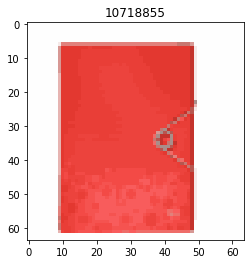

In [139]:
getColorPctPerImage();

################################################### JULIAS CODE ##############################################################

In [ ]:
color_mappings = {
  # source color => arr of colors associated with the source color
    'Grey' : ['Silver', 'Metallic', 'Aluminium', 'Stainless steel', 'Platinum', 'Graphite', 'Chrome', 'Anthracite','Light Grey','Charcoal','Titanium','Light grey'],
    'Purple' : ['Violet', 'Lavender', 'Fuchsia','Magenta'],
    'Transparent' : ['Translucent'],
    'Cream' : ['Beige', 'Sand', 'Tan','Cappuccino','Ivory'],
    'Brown' : ['Oak colour', 'Wood','Bronze'],
    'Cyan' : ['Turquoise', 'Aqua colour'],
    'White' : ['Pearl' ],
    'Pink' : ['Rose'],
    'Red' : ['Cherry', 'Bordeaux'],
    'Green' : ['Pine', 'Lime','Olive'],
    'Yellow' : ['Gold'],
    'Blue' : ['Navy'],
    'Multicolour' : ['Multi','Assorted colours']
}

def colors_binning(initial_color):
    for source_color in color_mappings:
        if initial_color in color_mappings[source_color]: return source_color;
        
    return initial_color;
        
colours = []
with open("datasets/1/colors.txt","r") as file:
    colors = ast.literal_eval(file.read())
    count = 0 
    # lets create a dataframe
    d = {'color': []}
    for row in colors:
        # check if there are more colors in one row
        colors_arr = row[1].split(", ")
        #d['pic_id'].append(row[0])
        d['color'].append(colors_binning(colors_arr[0])) 
        colours.append(colors_binning(colors_arr[0]))

    pic_colors = pd.DataFrame(data=d) #our y/target values
    display(pic_colors)
    # lets see the distribution of colors. We will try to bin the repeating colors to the most common alternatives.
    display(pic_colors.color.value_counts())
    print(count) #number of multiple colour products

In [140]:
def load_image_files(container_path, dimension=(64, 64)):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    images = []
    flat_data = []
    target = []
    count_2d = 0
    count_rgb = 0
    count_other = 0
    count_rgba = 0
    count = 0
    img_hash = {}
    for file in image_dir.iterdir():
        #count += 1
        #if count > 10:
         #   break;
        img = plt.imread(file)    
        
        img_pred = cv.resize(img, (50, 50), interpolation=cv.INTER_AREA)
        #plt.imshow(img_pred)
        #img_pred = img_to_array(img_pred)
        img_pred = img_pred / 255
        if img_pred.shape == (50, 50):
            img_pred = cv.cvtColor(img_pred.astype('float32'),cv.COLOR_GRAY2RGB)
        elif img_pred.shape == (50,50,3):
            count_rgb += 1
        elif img_pred.shape == (50,50,4):
            img_pred = cv.cvtColor(img_pred.astype('float32'),cv.COLOR_RGBA2RGB)
        else:
            count_other +=1
            print(img_pred.shape)
            
        images.append(img_pred)
        #img_hash[file.stem] = img_pred
    print("rgb: "+str(count_rgb)+ " 2d: "+str(count_2d)+" rgba: "+str(count_rgba)+ " other: "+str(count_other))
    return images

images_data = load_image_files("datasets/1/images") #our X/data set

rgb: 5776 2d: 0 rgba: 0 other: 0


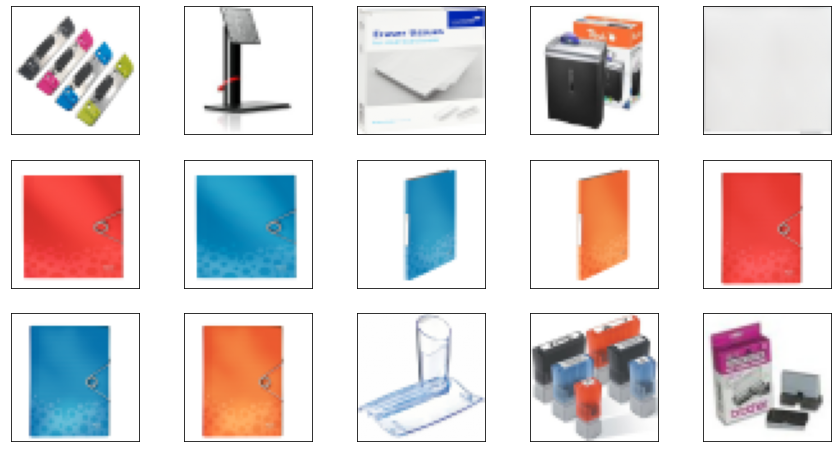

In [141]:
#show some images
fig, axes = plt.subplots(3, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for  image, ax in zip(images_data, axes.ravel()):
    ax.imshow(image)

In [ ]:
#reshape data so it fits 
arr = np.array(images_data)
nsamples, nx, ny, nz = arr.shape
d2_arr = arr.reshape((nsamples,nx*ny*nz))
d2_arr.shape
arr.shape

In [ ]:
# split the data in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    d2_arr, colours, stratify=colours, random_state=69)
# build a KNeighborsClassifier with using one neighbor:
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(X_train, y_train)
print("Train set score of 5-nn: {:.2f}".format(knn.score(X_train, y_train)))
print("Test set score of 5-nn: {:.2f}".format(knn.score(X_test, y_test)))

In [ ]:
#lets see how accuracy depends on number of neighbours
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 100)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend(); 

## 2. Flights Departing from NYC

__You should be able to do this exercise after Lecture 4.__

For this exercise we will be using the famous nycflights13 data which contains the `airlines`, `airports`, `flights`, `planes`, and `weather` datasets. Please see the documentation (`nycflights13.pdf`) for further information.

**(a)** Load all files as pandas dataframes and display the first 5 rows of each dataset.

In [4]:
#JULIA
#loading
airlines = pd.read_csv('datasets/2/airlines.csv')
airports = pd.read_csv('datasets/2/airports.csv')
flights = pd.read_csv('datasets/2/flights.csv')
planes = pd.read_csv('datasets/2/planes.csv')
weather = pd.read_csv('datasets/2/weather.csv')
#displaying
display(airlines.head())
display(airports.head())
display(flights.head())
display(planes.head())
display(weather.head())

,carrier,name
0,9E,Endeavor Air Inc.
1,AA,American Airlines Inc.
2,AS,Alaska Airlines Inc.
3,B6,JetBlue Airways
4,DL,Delta Air Lines Inc.


,faa,name,lat,lon,alt,tz,dst,tzone
0,04G,Lansdowne Airport,41.130472,-80.619583,1044,-5.0,A,America/New_York
1,06A,Moton Field Municipal Airport,32.460572,-85.680028,264,-6.0,A,America/Chicago
2,06C,Schaumburg Regional,41.989341,-88.101243,801,-6.0,A,America/Chicago
3,06N,Randall Airport,41.431912,-74.391561,523,-5.0,A,America/New_York
4,09J,Jekyll Island Airport,31.074472,-81.427778,11,-5.0,A,America/New_York


,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400,5.0,17.0
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416,5.0,33.0
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089,5.0,42.0
3,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762,5.0,54.0
4,2013,1,1,554.0,-4.0,740.0,12.0,UA,N39463,1696,EWR,ORD,150.0,719,5.0,54.0


,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
0,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan
1,N102UW,1998.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
2,N103US,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
3,N104UW,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
4,N10575,2002.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan


,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,37.04,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2013-01-01T00:00:00Z
1,EWR,2013,1,1,1,37.04,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2013-01-01T01:00:00Z
2,EWR,2013,1,1,2,37.94,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2013-01-01T02:00:00Z
3,EWR,2013,1,1,3,37.94,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2013-01-01T03:00:00Z
4,EWR,2013,1,1,4,37.94,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2013-01-01T04:00:00Z


**(b)** Convert all temperature attributes to degree Celsius. We will be using this in what follows.

In [5]:
#JULIA
weather['temp'] = (weather['temp']-32)*5/9
weather['temp']

0        2.8
1        2.8
2        3.3
3        3.3
4        3.3
        ... 
26125    2.2
26126    1.1
26127    0.0
26128   -0.6
26129   -1.7
Name: temp, Length: 26130, dtype: float64

**(c)** Using OLS, investigate if flight distance is associated with arrival delay. You should be cautious regarding negative delays.

R^2 on train data is 0.0005788038321236089 and on test data is 0.00024372663477112422
The coefficents are [-0.00131288] and the intercept is 3.893709244732308
           arr_delay  distance
arr_delay    1.00000  -0.02094
distance    -0.02094   1.00000


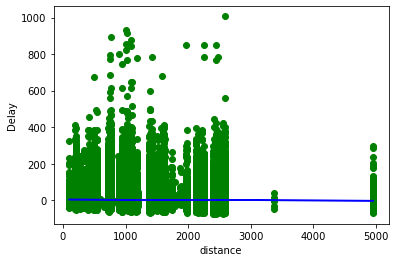

R^2 on train data is 2.2108193384440256e-05 and on test data is -4.7688311769711333e-05
The coefficents are [0.00031661] and the intercept is 35.98106341556762
           arr_delay  distance
arr_delay   1.000000  0.001957
distance    0.001957  1.000000


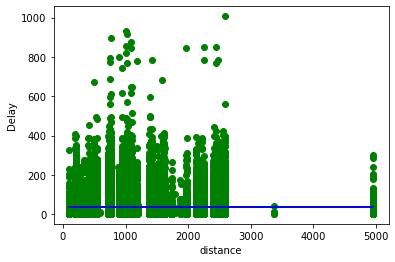

R^2 on train data is 0.032744467226592966 and on test data is 0.029405618327360106
The coefficents are [-0.00268046] and the intercept is -14.277652851055828
           arr_delay  distance
arr_delay   1.000000 -0.176971
distance   -0.176971  1.000000


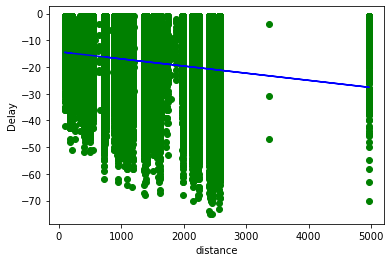

In [99]:
#JULIA

positive_delays = flights[flights['arr_delay']>0]
negative_delays = flights[flights['arr_delay']<0]

def plotRegression(feature,df):
    df = df.dropna(subset=[feature,'arr_delay'])
    X = df[[feature]]
    y = df['arr_delay']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    ODS = LinearRegression()
    ODS.fit(X_train, y_train)

    print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train),ODS.score(X_test,y_test)))
    print("The coefficents are {} and the intercept is {}".format(ODS.coef_, ODS.intercept_))
    print(df[['arr_delay',feature]].corr())
    
    y_pred = ODS.predict(X)
    plt.scatter(X, y,color = "green") 
    plt.plot(X[feature], y_pred,color = "blue")
    plt.xlabel(feature)
    plt.ylabel("Delay")
    plt.show()

plotRegression('distance',flights) #All fligths 
plotRegression('distance',positive_delays)#flights with only positive delays
plotRegression('distance',negative_delays)#flights with only negative delays


### Conclusions
According to graphs above the arrival delay and distance are correlated almost only in case of negative delays. That means that flights flying further distances were deleyed less(so they arrived sooner) than flights flying short distances, but that's true mostly only for when the flights departed ealier than scheduled(3rd graph). For flights with regular(positive) delays there's hardly any correlation between delay time and distance(2nd graph). Concluding, there's very little correlation between two features and it's mostly influenced by negative delays. 

**(d)** Using OLS, investigate if departure delay is associated with arrival delay. Again,
   consider what to do with negative delays.

R^2 on train data is 0.7965460865263717 and on test data is 0.7906647024883411
The coefficents are [1.01274657] and the intercept is -7.417388777894841
           arr_delay  dep_delay
arr_delay    1.00000    0.89087
dep_delay    0.89087    1.00000


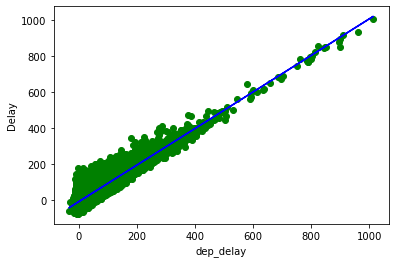

R^2 on train data is 0.8690006853075694 and on test data is 0.8729099919553227
The coefficents are [0.93268977] and the intercept is 4.297628297012203
           arr_delay  dep_delay
arr_delay   1.000000   0.933274
dep_delay   0.933274   1.000000


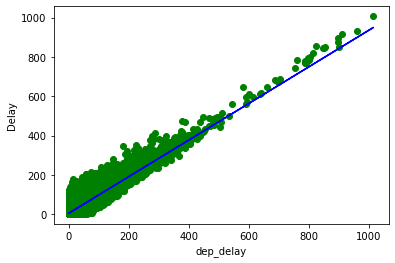

R^2 on train data is 0.011839811251317611 and on test data is 0.01329006860170523
The coefficents are [0.46206534] and the intercept is -16.43808823228722
           arr_delay  dep_delay
arr_delay   1.000000   0.113862
dep_delay   0.113862   1.000000


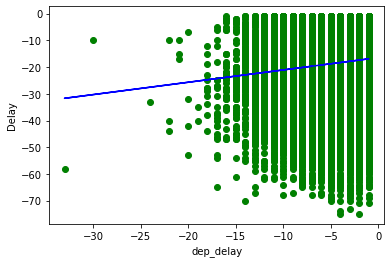

In [100]:
#JULIA

positive_delays = flights[((flights['dep_delay']>0) & (flights['arr_delay']>0))]
negative_delays = flights[((flights['dep_delay']<0) & (flights['arr_delay']<0))]

def plotRegression(feature,df):
    df = df.dropna(subset=[feature,'arr_delay'])
    X = df[[feature]]
    y = df['arr_delay']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    ODS = LinearRegression()
    ODS.fit(X_train, y_train)

    print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train),ODS.score(X_test,y_test)))
    print("The coefficents are {} and the intercept is {}".format(ODS.coef_, ODS.intercept_))
    print(df[['arr_delay',feature]].corr())
    
    y_pred = ODS.predict(X)
    plt.scatter(X, y,color = "green") 
    plt.plot(X[feature], y_pred,color = "blue")
    plt.xlabel(feature)
    plt.ylabel("Delay")
    plt.show()

plotRegression('dep_delay',flights) #All fligths 
plotRegression('dep_delay',positive_delays)#flights with only positive delays
plotRegression('dep_delay',negative_delays)#flights with only negative delays



### Conclusions
The correlation between departure and arrival time is big in case of late flights but little in case of fligts that departed before expected time. So the correlations between these two is high but lowered by negative delays where arrival delay doesn't seem to be influenced by how early(earlier than expected time) the flight departed. It could be explained by fact that if flight departed ealier than expected it won't rush and usually land in planned time as it's probably scheduled and airports might not often allow early arrivals(it's just hypothesis :)). 

**(e)** Investigate whether departure delay is associated with weather conditions
   at the origin airport. This includes descriptives, plotting, regression modelling,
   considering missing values etc. For regression, do OLS, Ridge, Lasso, and Elastic Net.
   The analysis should also include seasonality trends as a "weather condition". You could,
   for instance, plot the daily departure delay with the date (or monthly). What are the
   three most important weather conditions when trying to predict departure delays?

In [6]:
#JULIA
display(flights.head())
display(weather.head())
#remove flights with no hour data - unable to be merged with weather data
flights_complete = flights.dropna(subset=['hour'])
#remove unrelated features
flights_complete = flights_complete.drop(columns=['carrier', 'tailnum','flight','dest','air_time','distance','arr_delay','arr_time','minute'])
flights_complete.info()
weather.info()

scaler = MinMaxScaler()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400,5.0,17.0
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416,5.0,33.0
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089,5.0,42.0
3,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762,5.0,54.0
4,2013,1,1,554.0,-4.0,740.0,12.0,UA,N39463,1696,EWR,ORD,150.0,719,5.0,54.0


,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,0,2.8,21.92,53.97,230.0,10.35702,11.918651,0.0,1013.9,10.0,2013-01-01T00:00:00Z
1,EWR,2013,1,1,1,2.8,21.92,53.97,230.0,13.80936,15.891535,0.0,1013.0,10.0,2013-01-01T01:00:00Z
2,EWR,2013,1,1,2,3.3,21.92,52.09,230.0,12.65858,14.567241,0.0,1012.6,10.0,2013-01-01T02:00:00Z
3,EWR,2013,1,1,3,3.3,23.00,54.51,230.0,13.80936,15.891535,0.0,1012.7,10.0,2013-01-01T03:00:00Z
4,EWR,2013,1,1,4,3.3,24.08,57.04,240.0,14.96014,17.215830,0.0,1012.8,10.0,2013-01-01T04:00:00Z


<class 'pandas.core.frame.DataFrame'>
Int64Index: 158418 entries, 0 to 160753
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   year       158418 non-null  int64  
 1   month      158418 non-null  int64  
 2   day        158418 non-null  int64  
 3   dep_time   158418 non-null  float64
 4   dep_delay  158418 non-null  float64
 5   origin     158418 non-null  object 
 6   hour       158418 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 9.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26130 entries, 0 to 26129
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   origin      26130 non-null  object 
 1   year        26130 non-null  int64  
 2   month       26130 non-null  int64  
 3   day         26130 non-null  int64  
 4   hour        26130 non-null  int64  
 5   temp        26129 non-null  float64
 6   dewp        26129

In [7]:
#merging weather and flights data and leaving only ones with departure delay non-nan values
flight_weather = pd.merge(flights_complete, weather, how='outer', on=['origin', 'year','month','day','hour'])
flight_weather = flight_weather.drop(columns=['origin','time_hour','year'])
flight_weather = flight_weather.dropna(subset=['dep_delay'])


#flight_weather[feature] = scaler.fit_transform(flight_weather[[feature]])

flight_weather.head()
flight_weather.info()
flight_weather.describe()

flight_weather = flight_weather[flight_weather["wind_speed"] < 1000] #there's outlier that is probably error, because it's impossible for wind speed to be above 1000mph(The Highest Anemometer-Measured Wind Speeds on Earth, 2022)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158418 entries, 0 to 158417
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   month       158418 non-null  int64  
 1   day         158418 non-null  int64  
 2   dep_time    158418 non-null  float64
 3   dep_delay   158418 non-null  float64
 4   hour        158418 non-null  float64
 5   temp        157798 non-null  float64
 6   dewp        157798 non-null  float64
 7   humid       157798 non-null  float64
 8   wind_dir    154677 non-null  float64
 9   wind_speed  157792 non-null  float64
 10  wind_gust   157792 non-null  float64
 11  precip      157804 non-null  float64
 12  pressure    140679 non-null  float64
 13  visib       157804 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 18.1 MB


In [9]:
#now trying to get rid of missing value I'm using regression imputing for it
missing_columns = ["temp", "dewp", "humid", "wind_dir", "wind_speed","wind_gust","precip","pressure","visib"]
#firstly random impute missing values - we have multiple variables with missing values so some predictors woud be nan and it wouldn't work
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

for feature in missing_columns:
    flight_weather[feature + '_imp'] = flight_weather[feature]
    flight_weather = random_imputation(flight_weather, feature)
    
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

#using linear regression to input all the random imputed values with result of lin. regression for each feature with missing values
for feature in missing_columns:
        
    deter_data["Det" + feature] = flight_weather[feature + "_imp"]
    parameters = list(set(flight_weather.columns) - set(missing_columns) - {feature + '_imp'})
    model = LinearRegression()
    model.fit(X = flight_weather[parameters], y = flight_weather[feature + '_imp'])
    deter_data.loc[flight_weather[feature].isnull(), "Det" + feature] = model.predict(flight_weather[parameters])[flight_weather[feature].isnull()]
    flight_weather[feature] = deter_data["Det" + feature]
    flight_weather = flight_weather.drop(columns=[feature + "_imp"])
    

flight_weather.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 157778 entries, 10 to 158417
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   month       157778 non-null  int64  
 1   day         157778 non-null  int64  
 2   dep_time    157778 non-null  float64
 3   dep_delay   157778 non-null  float64
 4   hour        157778 non-null  float64
 5   temp        157778 non-null  float64
 6   dewp        157778 non-null  float64
 7   humid       157778 non-null  float64
 8   wind_dir    157778 non-null  float64
 9   wind_speed  157778 non-null  float64
 10  wind_gust   157778 non-null  float64
 11  precip      157778 non-null  float64
 12  pressure    157778 non-null  float64
 13  visib       157778 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 18.1 MB


## OLS

In [10]:
    X = flight_weather.drop(columns=['dep_delay'])
    y = flight_weather['dep_delay']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    ODS = LinearRegression()
    ODS.fit(X_train, y_train)

    print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train),ODS.score(X_test,y_test)))
    print("the intercept is {}".format(ODS.intercept_))
    pd.Series(ODS.coef_, index=X.columns)
    

R^2 on train data is 0.10075238928220798 and on test data is 0.09958162903193613
the intercept is 227.52414109674848


month         -0.131248
day            0.044503
dep_time      -0.078109
hour          10.164733
temp          -0.785166
dewp           0.542069
humid          0.017995
wind_dir      -0.001644
wind_speed     0.058315
wind_gust      0.067107
precip        31.875523
pressure      -0.252217
visib         -0.360694
dtype: float64

#### Ploting OLS for each feature separately to see their correlation with dep delay time

In [11]:
def plotRegression(feature,flight_weather):
    #flight_weather[feature] = scaler.fit_transform(flight_weather[[feature]])
    X = flight_weather[[feature]]
    y = flight_weather['dep_delay']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    ODS = LinearRegression()
    ODS.fit(X_train, y_train)

    print("R^2 on train data is {} and on test data is {}".format(ODS.score(X_train, y_train),ODS.score(X_test,y_test)))
    print(flight_weather[['dep_delay',feature]].corr())
    
    y_pred = ODS.predict(X)
    plt.scatter(X, y,color = "green") 
    plt.plot(X[feature], y_pred,color = "blue")
    plt.xlabel(feature)
    plt.ylabel("Delay")
    plt.show()


R^2 on train data is 2.604902789582475e-06 and on test data is 1.8041653111922074e-05
           dep_delay     month
dep_delay   1.000000 -0.004049
month      -0.004049  1.000000


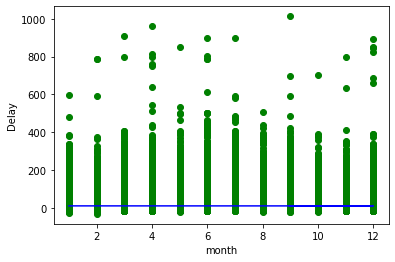

R^2 on train data is 1.0385410045832266e-05 and on test data is 5.5075189117959056e-05
           dep_delay       day
dep_delay   1.000000  0.006677
day         0.006677  1.000000


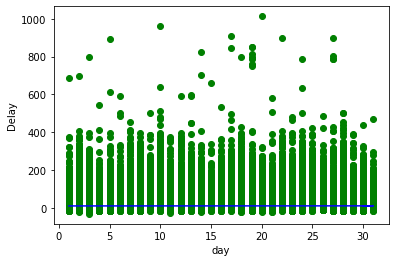

R^2 on train data is 0.06925841249332787 and on test data is 0.0710096366186499
           dep_delay  dep_time
dep_delay   1.000000  0.264808
dep_time    0.264808  1.000000


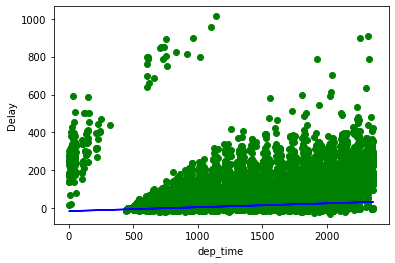

R^2 on train data is 1.0 and on test data is 1.0
           dep_delay  dep_delay
dep_delay        1.0        1.0
dep_delay        1.0        1.0


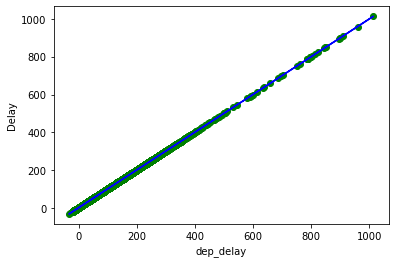

R^2 on train data is 0.0702803675402014 and on test data is 0.07191526684469918
           dep_delay      hour
dep_delay   1.000000  0.266623
hour        0.266623  1.000000


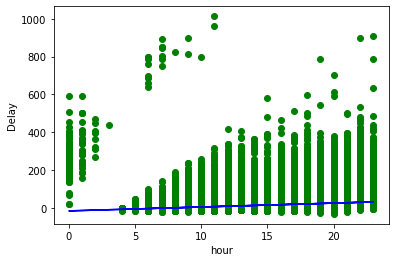

R^2 on train data is 0.011352329532960392 and on test data is 0.00955042208250223
           dep_delay      temp
dep_delay   1.000000  0.102399
temp        0.102399  1.000000


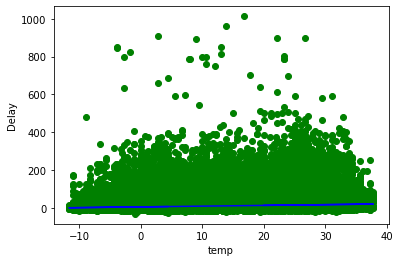

R^2 on train data is 0.01169698509996664 and on test data is 0.009350838808336648
           dep_delay      dewp
dep_delay   1.000000  0.102828
dewp        0.102828  1.000000


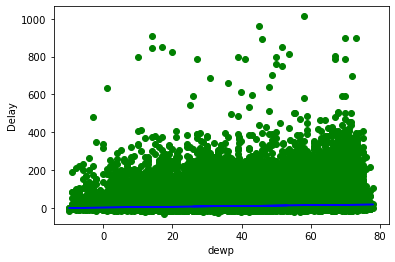

R^2 on train data is 0.001756931974440712 and on test data is 0.001034528782996147
           dep_delay    humid
dep_delay    1.00000  0.03769
humid        0.03769  1.00000


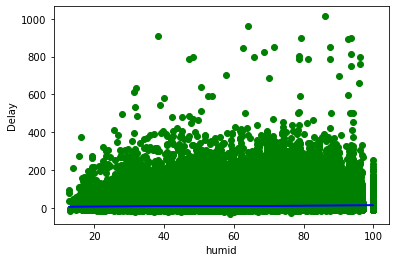

R^2 on train data is 0.0003799524605497817 and on test data is 0.00032257613174657696
           dep_delay  wind_dir
dep_delay    1.00000  -0.01878
wind_dir    -0.01878   1.00000


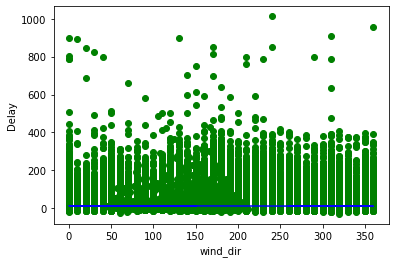

R^2 on train data is 0.0038912646317948996 and on test data is 0.004844122734088185
            dep_delay  wind_speed
dep_delay    1.000000    0.066127
wind_speed   0.066127    1.000000


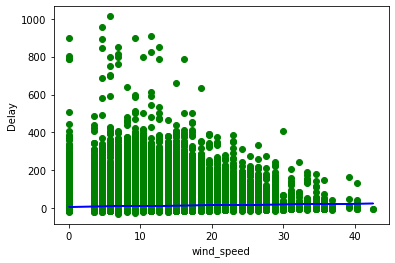

R^2 on train data is 0.0038912646317948996 and on test data is 0.004844122734088185
           dep_delay  wind_gust
dep_delay   1.000000   0.066127
wind_gust   0.066127   1.000000


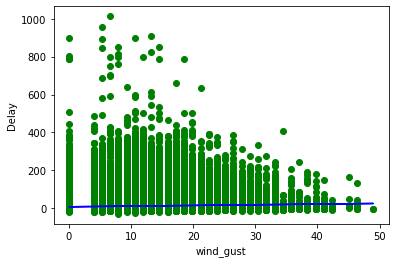

R^2 on train data is 0.0028820868297082525 and on test data is 0.0034898572979198406
           dep_delay    precip
dep_delay   1.000000  0.056434
precip      0.056434  1.000000


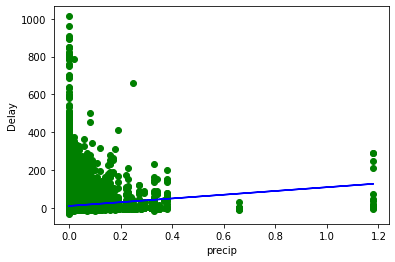

R^2 on train data is 0.010037226274070776 and on test data is 0.008605960748729657
           dep_delay  pressure
dep_delay    1.00000  -0.09669
pressure    -0.09669   1.00000


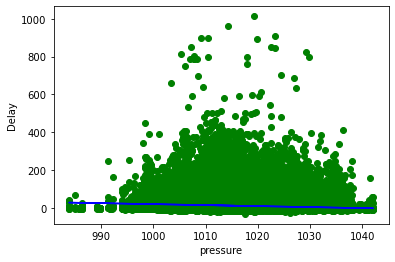

R^2 on train data is 0.008517466431148035 and on test data is 0.00873371520328503
           dep_delay     visib
dep_delay   1.000000 -0.092868
visib      -0.092868  1.000000


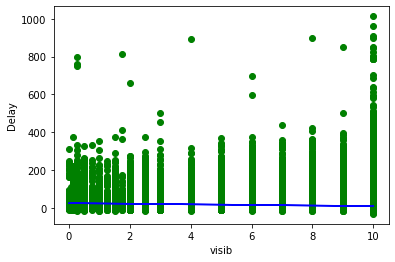

In [12]:
for feature in flight_weather.columns:
    plotRegression(feature,flight_weather)


R^2 on train data is 0.04774689307794877 and on test data is 0.04859518665351281
           dep_delay     month
dep_delay   1.000000  0.219468
month       0.219468  1.000000


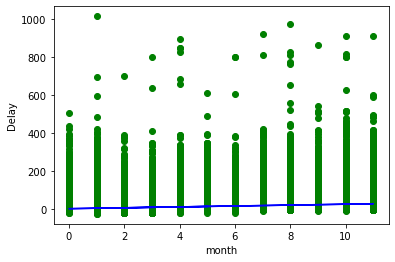

R^2 on train data is 0.10683748945901006 and on test data is 0.10929994389021047
           dep_delay      hour
dep_delay   1.000000  0.328715
hour        0.328715  1.000000


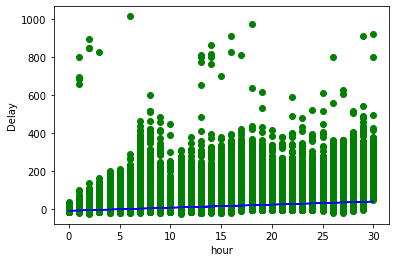

In [13]:
#Important to run this once only, if rerun needed then run data loading and preproccesing again
#the correlation for month might depend on which month we start counting from, so trying to plot it trying different months
flight_weather['month'] = flight_weather['month'] - 8
flight_weather[flight_weather['month']<0] = flight_weather[flight_weather['month']<0] + 12
plotRegression('month',flight_weather)
#same for hour
flight_weather['hour'] = flight_weather['hour'] - 5
flight_weather[flight_weather['hour']<0] = flight_weather[flight_weather['hour']<0] + 24
plotRegression('hour',flight_weather)

## Ridge



In [18]:
alphas = 10**np.linspace(-10, 10, 100)

for feature in flight_weather.columns:
    flight_weather[feature] = scaler.fit_transform(flight_weather[[feature]])

X = flight_weather.drop(columns=['dep_delay'])
y = flight_weather['dep_delay']
    
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)
temp_coefficients = [coef[0] for coef in coefs]
dewp_coefficients = [coef[1] for coef in coefs]
humid_coefficients = [coef[2] for coef in coefs]
wind_dir_coefficients = [coef[3] for coef in coefs]
wind_speed_coefficients = [coef[4] for coef in coefs]
wind_gust_coefficients = [coef[5] for coef in coefs]
precip_coefficients = [coef[6] for coef in coefs]
pressure_coefficients = [coef[7] for coef in coefs]
visib_coefficients = [coef[8] for coef in coefs]
month_coefficients = [coef[9] for coef in coefs]
day_coefficients = [coef[10] for coef in coefs]

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklea

Text(0, 0.5, 'weights')

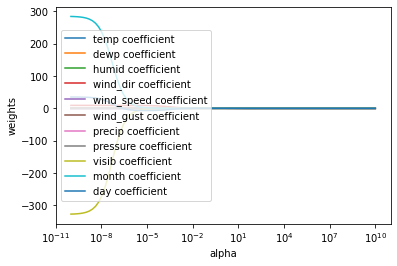

In [16]:
ax = plt.gca()
ax.set_xscale('log')
ax.plot(alphas, temp_coefficients, label="temp coefficient")
ax.plot(alphas, dewp_coefficients, label="dewp coefficient")
ax.plot(alphas, humid_coefficients, label="humid coefficient")
ax.plot(alphas, wind_dir_coefficients, label="wind_dir coefficient")
ax.plot(alphas, wind_speed_coefficients, label="wind_speed coefficient")
ax.plot(alphas, wind_gust_coefficients, label="wind_gust coefficient")
ax.plot(alphas, precip_coefficients, label="precip coefficient")
ax.plot(alphas, pressure_coefficients, label="pressure coefficient")
ax.plot(alphas, visib_coefficients, label="visib coefficient")
ax.plot(alphas, month_coefficients, label="month coefficient")
ax.plot(alphas, day_coefficients, label="day coefficient")
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [19]:
    #alphas = 10**np.linspace(10,-2,100)*0.5
    X = flight_weather.drop(columns=['dep_delay'])
    y = flight_weather['dep_delay']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)

    ridgecv = RidgeCV( normalize = True)#alphas = alphas,
    ridgecv.fit(X_train, y_train)
    print(ridgecv.alpha_)   
    print("R^2 on train data is {} and on test data is {}  ".format(ridgecv.score(X_train, y_train), ridgecv.score(X_test,y_test)))
    pd.Series(ridgecv.coef_, index = X.columns)

0.1
R^2 on train data is 0.14099765163972655 and on test data is 0.14048315187496718  


C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


month         0.026947
day           0.001966
dep_time      0.033828
hour          0.019976
temp         -0.002246
dewp          0.007962
humid         0.020758
wind_dir     -0.000877
wind_speed    0.003666
wind_gust     0.003730
precip        0.002354
pressure     -0.015641
visib        -0.006417
dtype: float64

## Lasso

In [20]:
lasso = Lasso(max_iter = 10000, normalize = True)
X = flight_weather.drop(columns=['dep_delay'])
y = flight_weather['dep_delay']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
lassocv = LassoCV(cv = 10, max_iter = 100000, normalize = True)#alphas = None,
lassocv.fit(X_train, y_train)
print(lassocv.alpha_)
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train),lassocv.score(X_test,y_test)))
pd.Series(lassocv.coef_, index=X.columns)

#lasso.set_params(alpha=lassocv.alpha_)
#lasso.fit(X_train, y_train)

#print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train),lassocv.score(X_test,y_test)))
#pd.Series(lasso.coef_, index=X.columns)

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


4.21431099273922e-08
R^2 on train data is 0.14342362001725362 and on test data is 0.14226421545094792


month         0.037722
day           0.002076
dep_time     -0.017375
hour          0.092150
temp         -0.037163
dewp          0.038759
humid         0.009314
wind_dir     -0.000281
wind_speed    0.000000
wind_gust     0.004598
precip       -0.044398
pressure     -0.018428
visib        -0.012305
dtype: float64

## Elastic Net

In [21]:

    X = flight_weather.drop(columns=['dep_delay'])
    y = flight_weather['dep_delay']
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
    #cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=69)
    ratios = [.1, .2, .3 , .4, .5, .7, .8, .9, .95, .99, 1]
    #alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
    en = ElasticNetCV(l1_ratio=ratios, cv=10, n_jobs=-1)
    en.fit(X_train, y_train)
    print('alpha: %f' % en.alpha_)
    print('l1_ratio_: %f' % en.l1_ratio_)
    print("R^2 on train data is {} and on test data is {}".format(en.score(X_train, y_train),en.score(X_test,y_test)))

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010010906824092558, tolerance: 0.00935208391655234
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012112768633244286, tolerance: 0.00935208391655234
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010158623273056833, tolerance: 0.009426927575532056
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010169079886551913, tolerance: 0.009407192198582874
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012252114361174904, tolerance: 0.009407192198582874
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011831285741251918, tolerance: 0.009316349029206047
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01825005842090377, tolerance: 0.00935208391655234
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024230088255990267, tolerance: 0.00935208391655234
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02902421377066844, tolerance: 0.00935208391655234
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0208550871720945, tolerance: 0.009407192198582874
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009978254573866252, tolerance: 0.009283174530682444
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024175806102618935, tolerance: 0.00935208391655234
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1514047518473376, tolerance: 0.009229343701240584
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016308455985779347, tolerance: 0.00939808446496956
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028838767429320455, tolerance: 0.00939808446496956
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0745173978726541, tolerance: 0.009407192198582874
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033676575581694124, tolerance: 0.009426927575532056
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05263715713078909, tolerance: 0.009426927575532056
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0369343684316874, tolerance: 0.00935208391655234
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05952773483005558, tolerance: 0.00935208391655234
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07478306874112661, tolerance: 0.00935208391655234
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022107769061392446, tolerance: 0.00939808446496956
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0483968852479677, tolerance: 0.00939808446496956
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0670094377438204, tolerance: 0.00939808446496956
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028024901909674327, tolerance: 0.009316349029206047
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05682603861639279, tolerance: 0.009316349029206047
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0772682052872824, tolerance: 0.009316349029206047
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023880605103855146, tolerance: 0.00939808446496956
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034180742487578186, tolerance: 0.009407192198582874
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.055502270328929626, tolerance: 0.00939808446496956
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04275451863722424, tolerance: 0.009426927575532056
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034936931214943456, tolerance: 0.009407192198582874
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024278034367043233, tolerance: 0.00939808446496956
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04254531540306061, tolerance: 0.00935208391655234
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031920252785639036, tolerance: 0.009282053581320048
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014672884843960787, tolerance: 0.009283174530682444
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033285650872784345, tolerance: 0.00923754680533208
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06435305478888154, tolerance: 0.00923754680533208
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024373185492024163, tolerance: 0.00939808446496956
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

alpha: 0.000003
l1_ratio_: 1.000000
R^2 on train data is 0.14315700486988836 and on test data is 0.14203605887306991


C:\Users\tanki\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e-01, tolerance: 1.035e-02
  model = cd_fast.enet_coordinate_descent(


## Conclusions
After building regression on weather data with different models it's visible that the most 'influencial' parameter is hour. Top three are: hour, month and precip(now it depends on model). Weather conditions don't really influence deperture delay much therefore it's hard to build good regression model on it.

**(f)** Is the age of the plane associated with delay? Do OLS, Ridge, Lasso, and Elastic Net.

In [ ]:
#==

**(g)** Do a principal component analysis of the weather at JFK using the following columns:
   temp, dewp, humid, wind_dir, wind_speed, precip, visib.
   How many principal components should be used to capture the variability in the weather data?

**(h)** Build regression models (OLS, Ridge, Lasso, and Elastic Net) that associates
   an airports lattitude with weather conditions (temp, dewp, humid, wind_dir, wind_speed,
   precip, visib). Remove all but the three most significant whether conditions and redo
   the analysis.

In [ ]:
#==

**(i)** On a map, plot the airports that have flights to them where the points that represent
   airports are relative in size to the average departure delay. You can see an example in "airports.png".

 **(j)** These questions require no code.
 - Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter or reduce it?

- Why would you want to use:
        > Ridge Regression instead of plain Linear Regression (i.e. without any regularization)?
        > Lasso instead of Ridge Regression?
        > Elastic Net instead of Lasso?

## 3. Clustering of Handwritten Digits

__You should be able to do this exercise after Lecture 5.__

This exercise will depart from the famous MNIST dataset, and we are exploring several clustering techniques with it.. This is a ".mat" file, in order to load this file in an ipynb you have to use loadmat() function from scipy.io. (replace my path).

In [1]:
from scipy.io import loadmat
mnist = loadmat('datasets/3/mnist-original')
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]
import numpy as np
print("Number of datapoints: {}\n".format(mnist_data.shape[0]))
print("Number of features: {}\n".format(mnist_data.shape[1]))
print("List of labels: {}\n".format(np.unique(mnist_label)))

Number of datapoints: 70000

Number of features: 784

List of labels: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]



There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels,
and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s `imshow()` function:

Value of datapoint no. 4:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  46 105 254 254 254 254 255 239  41
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  37
 118 222 254 253 253 253 253 253 253 211  54   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  14 200 253 253 254 253 253 253 253 253
 253 253 116   0   0   0   0   0   0   0   0   0   0   0   0   0  16 160
 236 253 253 253 254 253 

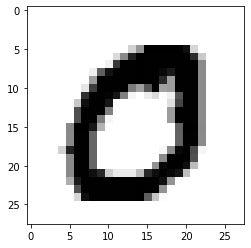

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
index = 4
print("Value of datapoint no. {}:\n{}\n".format(index,mnist_data[index]))
print("As image:\n")
plt.imshow(mnist_data[index].reshape(28,28),cmap=plt.cm.gray_r)
plt.show()

**(a)** Perform k-means clustering with k=10 on this dataset.

**(b)** Using visualization techniques analogous to what we have done in the Clustering notebook
   for the faces data, can you determine the 'nature' of the 10 constructed clusters?
   Do the clusters (roughly) coincide with the 10 different actual digits?

**(c)** Perform a supervised clustering evaluation using adjusted rand index.
   Are the results stable, when you perform several random restarts of k-means?

**(d)** Now perform hierarchical clustering on the data.
   (in order to improve visibility in the constructed dendrograms, you can also use a
   much reduced dataset as constructed using sklearn.utils.resample shown below).
   Does the visual analysis of the dendrogram indicate a natural number of clusters?

**(e)** Using different cluster distance metrics (ward,single,average, etc.),
   what do the clusterings look like that are produced at the level of k=10 clusters?
   See the Clustering notebook for the needed Python code, including the fcluster
   method to retrieve 'plain' clusterings from the hierarchical clustering.

In [3]:
small_mnist_data,small_mnist_label = skl.utils.resample(mnist.data,mnist.target,n_samples=200,replace='false')

NameError: name 'skl' is not defined

**(f)** Do a DBSCAN clustering of the small dataset. Tweak the different parameters.

**(g)** Try to compare the different clustering methods on the MNIST dataset in the same way
   the book does on the faces dataset on pp. 195-206.

## 4. The Local Elections

__You should be able to do this exercise after Lecture 6.__

In the local elections of 2021, around 100 candidates stood for election for the city council of Horsens. 83 of them represented a national party, had more than one candidate and provided answers to the <a href="https://www.dr.dk/nyheder/politik/kandidattest">DR Candidate Test</a>, a test designed to help voters find out who they should vote for. In this test, the candidates answered 18 questions, which we will use as features in the following. The politicians belong to 9 parties, which will be our classes.

The numpy files `X_Horsens.npy` and `Y_Horsens.npy` contains the data. `Y_Horsens.npy` contains a letter representing the party to which each candidate belongs. The following parties are represented:

| Party letter | Party name | Party name (English) | Political position | Party color |
| :-: | :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left | Red |
| B | Radikale Venstre | Social Liberal Party | Centre-left | Indigo |
| C | Det Konservative Folkeparti | Conservative People's Party | Right-wing | Green |
| D | Nye Borgerlige | New Right | Far-right | Black |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing | Fuchsia |
| I | Liberal Alliance | Liberal Alliance | Right-wing | Cyan |
| O | Dansk Folkeparti | Danish People's Party | Far-right | Yellow |
| V | Venstre | Danish Liberal Party | Centre-right | Blue |
| Z* | Enhedslisten | Red-Green Alliance | Far-left | Dark red |

*_Note that, although the party letter of Enhedslisten is actually Ø, we will here use Z to avoid any complications with the wonderful Danish letters Æ, Ø and Å. Feel free to change the Z back to an Ø if you find that it does not cause any problems._

Meanwhile, `X_Horsens.npy` contains the answers to the test as numbers between -1.5 and 1.5, such that -1.5 is "Strongly disagree", -0.5 is "Disagree", 0.5 is "Agree" and 1.5 is "Strongly agree". The 18 questions concern, in order, subdivision, schools, windmills, building permits, tall buildings, housing, child care, culture, nursing homes, taxes, sports, refugees, nursing homes (again), public transportation, meat-free days, welfare, privatization, and religious minorities.

Both files can be imported using `numpy.load`.

__(a)__ How well do you (intuitively) expect that we can predict the partisan affiliation of a candidate based on their answers to the test?

It might be around 50-60%. There will be problem with politicians with from parties ideologically simillar. Also dataset isn't big, with 100 entries and 9 classes there might not be enough of data to learn model well enough. 

__(b)__ Based on the answers from all 83 candidates for the Horsens city council, perform a Principal Component Analysis with 2 principal components. Plot the results in a figure using these 2 components as the axes. Label the points with the party letter and the appropriate color.

In [3]:
X_Horsens = np.load('datasets/4/X_Horsens.npy')
Y_Horsens = np.load('datasets/4/Y_Horsens.npy')
X_train, X_test , y_train, y_test = train_test_split(X_Horsens, Y_Horsens, test_size=0.5, random_state=69)

Xs = StandardScaler().fit_transform(X_Horsens)
pca = decomposition.PCA(n_components=1)
res = pca.fit_transform(Xs)
pca.explained_variance_ratio_

print(pd.DataFrame(pca.components_,columns=list(range(0, 18)),index = ['PC-1']))#,'PC-2'
#pca.components_

            0         1         2         3         4         5         6   \
PC-1  0.150294 -0.041177 -0.225587  0.211652  0.048277 -0.217779  0.256121   

            7         8         9         10        11        12        13  \
PC-1 -0.228058  0.193362  0.318774  0.061752 -0.296982  0.261643 -0.322831   

            14        15        16        17  
PC-1 -0.235702  0.279074  0.315304  0.275889  


[0.43036013 0.10128485]


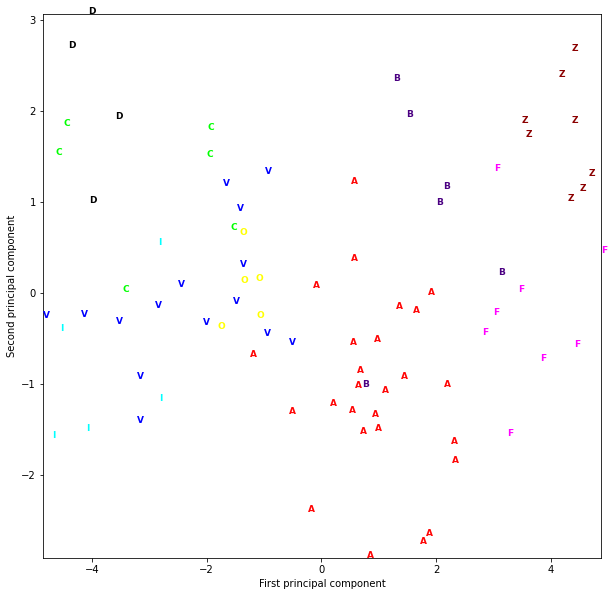

In [4]:
# build a PCA model
pca = decomposition.PCA(n_components=2)
pca.fit(X_Horsens)
# transform the digits data onto the first two principal components
parties_pca = pca.transform(X_Horsens)
colors = { "A":"#FF0707","B":"#4B0082","C":"#00FF00","D":"#000000","F" :"#FF00FF",
          "I":"#00FFFF","O":"#FFFF00","V":"#0000FF", "Z":"#8B0000"}


plt.figure(figsize=(10, 10))
plt.xlim(parties_pca[:, 0].min(), parties_pca[:, 0].max())
plt.ylim(parties_pca[:, 1].min(), parties_pca[:, 1].max())
for i in range(len(X_Horsens)):
    plt.text(parties_pca[i, 0], parties_pca[i, 1], str(Y_Horsens[i]),
             color = colors[Y_Horsens[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
print(pca.explained_variance_ratio_)

__(c)__ Comment on the results. You may consider the following questions for inspiration: Can the political parties be separated? Can the typical distinction of "left-wing" and "right-wing" be discerned? Which of the 18 questions (features) are most important?

[0.43036013 0.10128485]


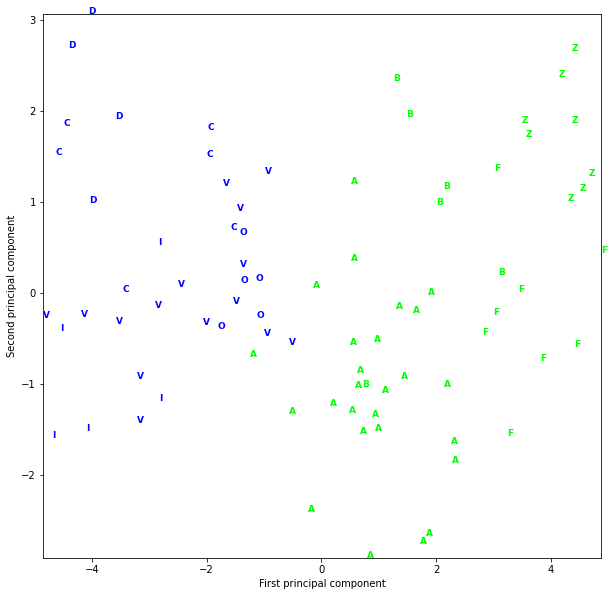

In [5]:
#to answer first two questions we will plot left-wing, right-wing and centrist parties with colours: green, blue, yellow
#only rigth and left
colors = { "A":"#00FF00","B":"#00FF00","C":"#0000FF","D":"#0000FF","F" :"#00FF00","I":"#0000FF","O":"#0000FF","V":"#0000FF", "Z":"#00FF00"}
#right, left and center:
#colors = { "A":"#FFFF00","B":"#FFFF00","C":"#0000FF","D":"#0000FF","F" :"#00FF00", "I":"#0000FF","O":"#0000FF","V":"#FFFF00", "Z":"#00FF00"}

plt.figure(figsize=(10, 10))
plt.xlim(parties_pca[:, 0].min(), parties_pca[:, 0].max())
plt.ylim(parties_pca[:, 1].min(), parties_pca[:, 1].max())
for i in range(len(X_Horsens)):
    plt.text(parties_pca[i, 0], parties_pca[i, 1], str(Y_Horsens[i]),
             color = colors[Y_Horsens[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
print(pca.explained_variance_ratio_)

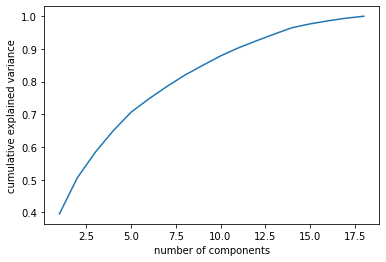

In [47]:
x = list(range(1, 1 + len(pca.explained_variance_ratio_)))
plt.plot(x, np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


The number of candidates (83) is on the (very) low side when we want to do machine learning. Luckily, the neighbouring city of Databorg had no less than 8,300 candidates standing for election, with a political environment similar to that of Horsens. In the following, we will use the data from Databorg. These are stored in the numpy files `X_Databorg.npy` and `Y_Databorg.npy` in same format as the Horsens data.

__(d)__ Once again, perform a Principal Component Analysis and visualize the results. Compare the results to those of the Horsens data.

Confident that we can predict the partisan affiliation of a politician reasonably well based on their answers to the test, we want to build a model that will allow us to distinguish between the 9 political parties. For this purpose, we split the data into a training and a validation set.

__(e)__ Split the data into a training and a validation set, with appropriate fractions.

First, we assume that a Naive Bayes approach is sufficient for our purposes.

__(f)__ Comment on the basic assumption of the Naive Bayes approach. Is this a reasonable assumption for the problem at hand?

__(g)__ Classify the instances of the validation set using a Naive Bayes approach. Comment on the results.

Assume instead that a _k_-nearest neighbour approach is sufficient for our  needs.

__(h)__ Using default settings of the _k_-NN classifier, classify the instances of the validation set. Comment on the performance.

__(i)__ Play around with different values of _k_. Decide on a "good" value of _k_. Comment on the results.

We now try to use a decision tree instead.

__(j)__ What is the _minimum_ depth of an appropriate decision tree? Why?

__(k)__ Build a decision tree with at least the depth from above. Play around with the tree depth. Include a figure that shows some relevant measure of the performance as a function of the tree depth. Comment on any issues of over-fitting. Decide on a tree which you will keep for later use. Can you do better than the _k_-NN classifier?

__(l)__ What are the most important features? Visualize this in an appropriate way. Does it match what you would expect? Compare to the results of the PCA analysis. Do we expect them to be the same? Why/why not?

We know that decision trees suffer from certain problems that may be solved by using decision forests.

__(m)__ Build a decision forest. Play around with the number of trees in the forest. Decide on a forest.

__(n)__ Extract the most important features. Comment and compare with previously obtained results.

Finally, we want to compare the models we have worked with so far (i.e., Naive Bayes, _k_-NN, decision tree and decision forest).

__(o)__ Compare the results of the in terms of confusion matrices, accuracy, precision, recall, and f-score. How well can we predict the partisan affiliation of a candidate based on their answers to a test? How does this compare with your intuition? 

## 5. Sentiment Analysis

__You should be able to do this exercise after Lecture 8.__

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [ ]:
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing.

**(b)** Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. (See an example of how to do this in chapter 7 of "Muller and Guido"). Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

**(c)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

**(d)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

**(e)** Test your sentiment-classifier on the test set.

**(h)** Use the classifier to classify a few sentences you write yourselves. 

## 6. Speech Recognition

__You should be able to do this exercise after Lecture 9.__

In this exercise, we will work with the <a href="https://arxiv.org/pdf/1804.03209.pdf">Google Speech Command Dataset</a>, which can be downloaded from <a href="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz">here</a> (note: you do not need to download the full dataset, but it will allow you to play around with the raw audiofiles). This dataset contains 105,829 one-second long audio files with utterances of 35 common words.

We will use a subset of this dataset as indicated in the table below.

| Word | How many? | Class # |
| :-: | :-: | :-: |
| Yes | 4,044 | 3 |
| No | 3,941 | 1 |
| Stop | 3,872 | 2 |
| Go | 3,880 | 0 |

The data is given in the files `XSound.npy` and `YSound.npy`, both of which can be imported using `numpy.load`. `XSound.npy` contains spectrograms (_e.g._, matrices with a time-axis and a frequency-axis of size 62 (time) x 65 (frequency)). `YSound.npy` contains the class number, as indicated in the table above.

__(a)__ Explore and prepare the data, including splitting the data in training, validation and testing data, handling outliers, perhaps taking logarithms, etc. Data preparation is - as always - quite important. Document what you do.

__(b)__ Visualize a few examples of yes's, no's, stop's and go's, so that you have a reasonable intuitive understanding of the difference between the words.

__(c)__ Train a neural network and at least one other algorithm on the data. Find a good set of hyperparameters for each model. Do you think a neural network is suitable for this kind of problem? Why/why not?

__(d)__ Classify instances of the validation set using your models. Comment on the results in terms of metrics you have learned in the course.

__(e)__ Identify (a few) misclassified words, including what they are misclassified as. Visualize them as before, and compare with your intuitive understanding of how the words look. Do you find the misclassified examples surprising?

## 7. Group Assignment & Presentation



__You should be able to start up on this exercise after Lecture 1.__

*This exercise must be a group effort. That means everyone must participate in the assignment.*

In this assignment you will solve a data science problem end-to-end, pretending to be recently hired data scientists in a company. To help you get started, we've prepared a checklist to guide you through the project. Here are the main steps that you will go through:

1. Frame the problem and look at the big picture
2. Get the data
3. Explore and visualise the data to gain insights
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models
7. Present your solution 

In each step we list a set of questions that one should have in mind when undertaking a data science project. The list is not meant to be exhaustive, but does contain a selection of the most important questions to ask. We will be available to provide assistance with each of the steps, and will allocate some part of each lesson towards working on the projects.

Your group must submit a _**single**_ Jupyter notebook, structured in terms of the first 6 sections listed above (the seventh will be a video uploaded to some streaming platform, e.g. YouTube, Vimeo, etc.).

### 1. Analysis: Frame the problem and look at the big picture
1. Find a problem/task that everyone in the group finds interesting
2. Define the objective in business terms
3. How should you frame the problem (supervised/unsupervised etc.)?
4. How should performance be measured?

### 2. Get the data
1. Find and document where you can get the data from
2. Get the data
3. Check the size and type of data (time series, geographical etc)

### 3. Explore the data
1. Create a copy of the data for explorations (sampling it down to a manageable size if necessary)
2. Create a Jupyter notebook to keep a record of your data exploration
3. Study each feature and its characteristics:
    * Name
    * Type (categorical, int/float, bounded/unbounded, text, structured, etc)
    * Percentage of missing values
    * Check for outliers, rounding errors etc
4. For supervised learning tasks, identify the target(s)
5. Visualise the data
6. Study the correlations between features
7. Identify the promising transformations you may want to apply (e.g. convert skewed targets to normal via a log transformation)
8. Document what you have learned

### 4. Prepare the data
Notes:
* Work on copies of the data (keep the original dataset intact).
* Write functions for all data transformations you apply, for three reasons:
    * So you can easily prepare the data the next time you run your code
    * So you can apply these transformations in future projects
    * To clean and prepare the test set
    
    
1. Data cleaning:
    * Fix or remove outliers (or keep them)
    * Fill in missing values (e.g. with zero, mean, median, regression ...) or drop their rows (or columns)
2. Feature selection (optional):
    * Drop the features that provide no useful information for the task (e.g. a customer ID is usually useless for modelling).
3. Feature engineering, where appropriate:
    * Discretize continuous features
    * Use one-hot encoding if/when relevant
    * Add promising transformations of features (e.g. $\log(x)$, $\sqrt{x}$, $x^2$, etc)
    * Aggregate features into promising new features
4. Feature scaling: standardise or normalise features

### 5. Short-list promising models
We expect you to do some additional research and train at **least one model per team member**.

1. Train mainly quick and dirty models from different categories (e.g. linear, SVM, Random Forests etc) using default parameters
2. Measure and compare their performance
3. Analyse the most significant variables for each algorithm
4. Analyse the types of errors the models make
5. Have a quick round of feature selection and engineering if necessary
6. Have one or two more quick iterations of the five previous steps
7. Short-list the top three to five most promising models, preferring models that make different types of errors

### 6. Fine-tune the system
1. Fine-tune the hyperparameters
2. Once you are confident about your final model, measure its performance on the test set to estimate the generalisation error

### 7. Present your solution
1. Document what you have done
2. Create a nice 15 minute video presentation with slides
    * Make sure you highlight the big picture first
3. Explain why your solution achieves the business objective
4. Don't forget to present interesting points you noticed along the way:
    * Describe what worked and what did not
    * List your assumptions and you model's limitations
5. Ensure your key findings are communicated through nice visualisations or easy-to-remember statements (e.g. "the median income is the number-one predictor of housing prices")
6. Upload the presentation to some online platform, e.g. YouTube or Vimeo, and supply a link to the video in the notebook.

## References

Géron, A. 2017, *Hands-On Machine Learning with Scikit-Learn and Tensorflow*, Appendix B, O'Reilly Media, Inc., Sebastopol.
Wunderground.com. 2022. The Highest Anemometer-Measured Wind Speeds on Earth. Available at: <https://www.wunderground.com/cat6/the-highest-anemometer-measured-wind-speeds-on-earth#:~:text=253%20mph%20%E2%80%A2%20Barrow%20Island%2C%20Australia%20%E2%80%A2%20April%2010%2C%201996&text=Wind%20trace%20taken%20at%20Barrow,6%3A15%20pm%20local%20time.> [Accessed 11 October 2022].